# Neural EV Dynamics Simulation Walkthrough

This notebook demonstrates end-to-end usage of the transformer-based EV longitudinal controllers:

1. Load Stage 1 (forward/inverse) and Stage 2 (feedback) models.
2. Generate synthetic speed and grade profiles (or load from disk).
3. Run forward-only, inverse-only, and closed-loop simulations with perturbations.
4. Visualize the trajectories and error statistics.



In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))



In [2]:
import json
from pathlib import Path
from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import time as pytime

from scripts.simulate_profiles import (
    PerturbationConfig,
    load_models,
    simulate_forward,
    simulate_inverse,
    simulate_closed_loop,
    SequenceWindowConfig,
)


## 1. Paths and Configuration
Fill in the checkpoint paths and simulation hyperparameters. The defaults below assume you ran Stage 1/2 trainings from the earlier walkthrough.



In [ ]:
# Update these paths to match your environment
STAGE1_CKPT = Path("../checkpoints/stage1/horizon200_weighted/stage1_best.pth")
STAGE2_CKPT = Path("../checkpoints/stage2/horizon200/stage2.pth")
DATASET_PATH = Path("../data/processed/ECentro/ECENTRO_HA_03/all_trips_data.pt")

HISTORY = 50
HORIZON = 200
TOTAL_LENGTH = 1200  # total timesteps to simulate for closed-loop mode
SAMPLE_TIME = 0.1  # controller timestep in seconds
WARMUP_DURATION = 15.0  # seconds for ramp-to-initial-speed warmup

# Target speed profile options
TARGET_PROFILE_TYPE = "steps"  # options: "sine", "steps"
# Sequence of (duration_seconds, speed_mps) applied after the warm-up when TARGET_PROFILE_TYPE == "steps"
STEP_PROFILE_SEGMENTS = [
    (30.0, 1.5),
    (30.0, 5.0),
    (30.0, 3.0),
    (30.0, 7.0),
    (10.0, 0.0),
]

STATE_FEATURES = ["speed", "grade"]

window = SequenceWindowConfig(history=HISTORY, horizon=HORIZON)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## 2. Load Models



In [4]:
forward_model, inverse_model, feedback_model = load_models(
    STAGE1_CKPT,
    STAGE2_CKPT,
    state_dim=len(STATE_FEATURES),
    action_dim=2,
    device=device,
)

def count_params(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

print("Models loaded on", device)
print(
    f"Forward params: {count_params(forward_model):,}",
    f"Inverse params: {count_params(inverse_model):,}",
    f"Feedback params: {count_params(feedback_model):,}",
    sep="\n",
)


Models loaded on cuda
Forward params: 3,229,442
Inverse params: 3,229,442
Feedback params: 3,230,466


/home/dor/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/opt/imagry/DynamicsNet/scripts/simulate_profiles.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for an

In [5]:
autoencoder = None
auto_mapper = None
print("Autoencoder warm-start disabled; using synthetic ramp warmup instead.")



Autoencoder warm-start disabled; using synthetic ramp warmup instead.


## 3. Generate Profiles
We will synthesise target speed and grade profiles. You can swap these with `np.load` calls if you have recorded trajectories.



In [6]:
time = np.arange(TOTAL_LENGTH)

INITIAL_TARGET_SPEED = 12.0 / 3.6  # 12 km/h

WARMUP_GRADIENT = 1.0  # m/s^2


def build_linear_warmup_schedule(gradient: float,
                                 target_speed: float = INITIAL_TARGET_SPEED,
                                 dt: float = SAMPLE_TIME) -> np.ndarray:
    gradient = float(max(gradient, 1e-4))
    steps = int(np.ceil(target_speed / (gradient * dt)))
    if steps < 1:
        steps = 1
    speeds = gradient * dt * np.arange(1, steps + 1, dtype=np.float32)
    return np.clip(speeds, 0.0, target_speed)


def build_target_speed_profile(
    warmup_schedule: np.ndarray,
    profile_type: str = "sine",
) -> np.ndarray:
    profile = np.ones_like(time, dtype=np.float32) * INITIAL_TARGET_SPEED
    warmup_steps = int(np.round(warmup_schedule.size))
    after_warmup_steps = warmup_steps
    remaining_steps = profile.size - after_warmup_steps
    if remaining_steps > 0:
        if profile_type == "sine":
            phase = np.arange(remaining_steps)
            profile[after_warmup_steps:] = INITIAL_TARGET_SPEED + 1.5 * np.sin(phase / 60.0)
        elif profile_type == "steps":
            idx = after_warmup_steps
            segments = STEP_PROFILE_SEGMENTS or [(remaining_steps * SAMPLE_TIME, float(INITIAL_TARGET_SPEED))]
            last_speed = float(INITIAL_TARGET_SPEED)
            for duration, speed in segments:
                steps = int(np.round(duration / SAMPLE_TIME))
                if steps <= 0:
                    continue
                end = min(idx + steps, profile.size)
                profile[idx:end] = float(speed)
                last_speed = float(speed)
                idx = end
                if idx >= profile.size:
                    break
            if idx < profile.size:
                profile[idx:] = last_speed
        else:
            raise ValueError(f"Unknown target profile type: {profile_type}")
    return profile


DEFAULT_WARMUP_SCHEDULE = build_linear_warmup_schedule(WARMUP_GRADIENT)
WARMUP_DURATION = DEFAULT_WARMUP_SCHEDULE.size * SAMPLE_TIME

TARGET_SPEED = build_target_speed_profile(DEFAULT_WARMUP_SCHEDULE, TARGET_PROFILE_TYPE)
GRADE_PROFILE = np.zeros_like(time, dtype=np.float32)

initial_speed = np.zeros(HISTORY, dtype=np.float32)
initial_grade_profile = np.zeros(HISTORY, dtype=np.float32)
initial_actions = np.zeros((HISTORY, 2), dtype=np.float32)

print(
    "Warm-start summary → speed=",
    float(initial_speed[-1]),
    "warmup gradient=",
    WARMUP_GRADIENT,
    "warmup duration [s]=",
    DEFAULT_WARMUP_SCHEDULE.size * SAMPLE_TIME,
    "first target speed=",
    float(TARGET_SPEED[0]),
    "grade=",
    float(initial_grade_profile[-1]),
    "actions(throttle, brake)=",
    tuple(initial_actions[-1]),
)
print("Target profile type=", TARGET_PROFILE_TYPE)
if TARGET_PROFILE_TYPE == "steps":
    total_segment_duration = sum(float(seg[0]) for seg in STEP_PROFILE_SEGMENTS)
    print("Step segments (duration [s], speed [m/s]):", STEP_PROFILE_SEGMENTS)
    print("Step profile total duration [s]=", total_segment_duration)



Warm-start summary → speed= 0.0 warmup gradient= 1.0 warmup duration [s]= 3.4000000000000004 first target speed= 3.3333332538604736 grade= 0.0 actions(throttle, brake)= (0.0, 0.0)
Target profile type= steps
Step segments (duration [s], speed [m/s]): [(30.0, 1.5), (30.0, 2.6), (30.0, 3.2), (30.0, 1.8)]
Step profile total duration [s]= 120.0


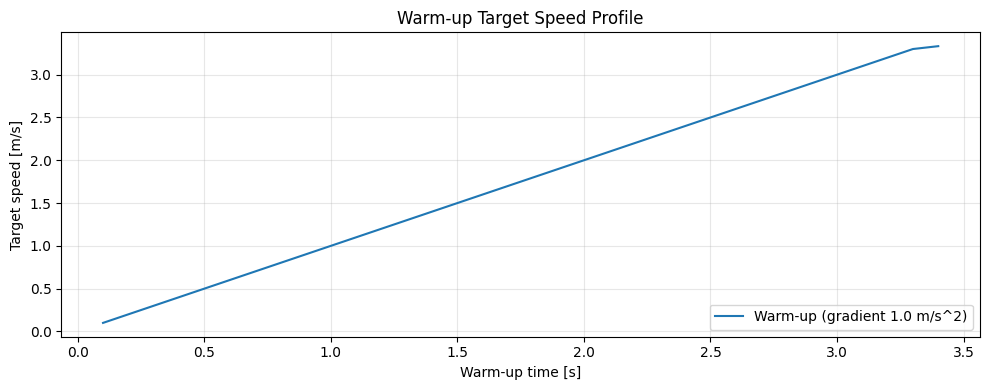

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
t_profile = np.arange(1, DEFAULT_WARMUP_SCHEDULE.size + 1) * SAMPLE_TIME
ax.plot(t_profile, DEFAULT_WARMUP_SCHEDULE, label=f"Warm-up (gradient {WARMUP_GRADIENT:.1f} m/s^2)")
ax.set_xlabel("Warm-up time [s]")
ax.set_ylabel("Target speed [m/s]")
ax.set_title("Warm-up Target Speed Profile")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()



## 4. Forward Simulation
Given a user-defined actuation horizon, predict the vehicle's future speed.



### Feedforward vs Feedback (Noiseless Simulation)



In [8]:
# Example actuation sequence: moderate throttle, no brake
actuation_horizon = np.zeros((HORIZON, 2), dtype=np.float32)
actuation_horizon[:, 0] = 40  # 40% throttle equivalent

forward_preds = simulate_forward(
    forward_model,
    initial_speed,
    initial_actions,
    actuation_horizon,
    GRADE_PROFILE[:HISTORY + HORIZON],
    window,
    STATE_FEATURES,
    device,
)
print("Forward-predicted speeds (first 10):", forward_preds[:10, 0])



Forward-predicted speeds (first 10): [-0.00512215 -0.0049379  -0.00512773 -0.0051403  -0.00493489 -0.00470833
 -0.00474189 -0.00500286 -0.00528909 -0.00533381]


## 5. Inverse Simulation
Given a target speed horizon, compute the required actuation plan (feedforward controller).



In [9]:
target_window = TARGET_SPEED[HISTORY : HISTORY + HORIZON]

inverse_actions = simulate_inverse(
    inverse_model,
    initial_speed,
    initial_actions,
    target_window,
    GRADE_PROFILE[:HISTORY + HORIZON],
    window,
    STATE_FEATURES,
    device,
)
print("Inverse-predicted throttle/brake (first 10 rows):\n", inverse_actions[:10])



Inverse-predicted throttle/brake (first 10 rows):
 [[ 7.8057537  0.       ]
 [ 8.514793   0.       ]
 [ 9.215492   0.       ]
 [10.164334   0.       ]
 [11.369717   0.       ]
 [13.305013   0.       ]
 [15.6524     0.       ]
 [17.159248   0.       ]
 [18.377237   0.       ]
 [19.086761   0.       ]]


## 6. Closed-loop Simulation
At each time step:
1. Feed the latest noisy measurements to the inverse (and optional feedback) model to obtain actuations.
2. Apply optional actuation noise.
3. Propagate the true state with the forward model (vehicle response).
4. Update history windows and continue.



In [10]:
def run_closed_loop_case(
    feedback_module,
    perturb,
    warmup_schedule: Optional[np.ndarray] = None,
):
    schedule = (
        np.asarray(warmup_schedule, dtype=np.float32)
        if warmup_schedule is not None
        else DEFAULT_WARMUP_SCHEDULE
    )
    warmup_seconds = schedule.size * SAMPLE_TIME
    return simulate_closed_loop(
        forward_model,
        inverse_model,
        feedback_module,
        initial_speed,
        initial_actions,
        TARGET_SPEED.copy(),
        GRADE_PROFILE.copy(),
        window,
        STATE_FEATURES,
        device,
        perturb=perturb,
        warmup_seconds=warmup_seconds,
        time_step=SAMPLE_TIME,
        warmup_speed_schedule=schedule,
    )

results_clean_ff = run_closed_loop_case(None, None)
results_clean_fb = run_closed_loop_case(feedback_model, None)

print(
    "Feedforward-only speed (first 10):",
    results_clean_ff["simulated_speed"][:10],
)
print(
    "With feedback speed (first 10):",
    results_clean_fb["simulated_speed"][:10],
)
print("Warmup duration [s] =", WARMUP_DURATION)



/opt/imagry/DynamicsNet/scripts/simulate_profiles.py:409: RuntimeWarning: Warmup did not converge within 0.100 m/s after 3400 iterations (last error=0.122).
  warnings.warn(
/opt/imagry/DynamicsNet/scripts/simulate_profiles.py:409: RuntimeWarning: Warmup did not converge within 0.100 m/s after 3400 iterations (last error=0.831).
  warnings.warn(


Feedforward-only speed (first 10): [3.2118137 3.2133882 3.2141805 3.2113793 3.2130551 3.2105005 3.2096317
 3.2098596 3.2104955 3.2107427]
With feedback speed (first 10): [2.5023003 2.5022676 2.504497  2.5077682 2.5139859 2.5157046 2.5152578
 2.5156174 2.5174775 2.5181994]
Warmup duration [s] = 3.4000000000000004


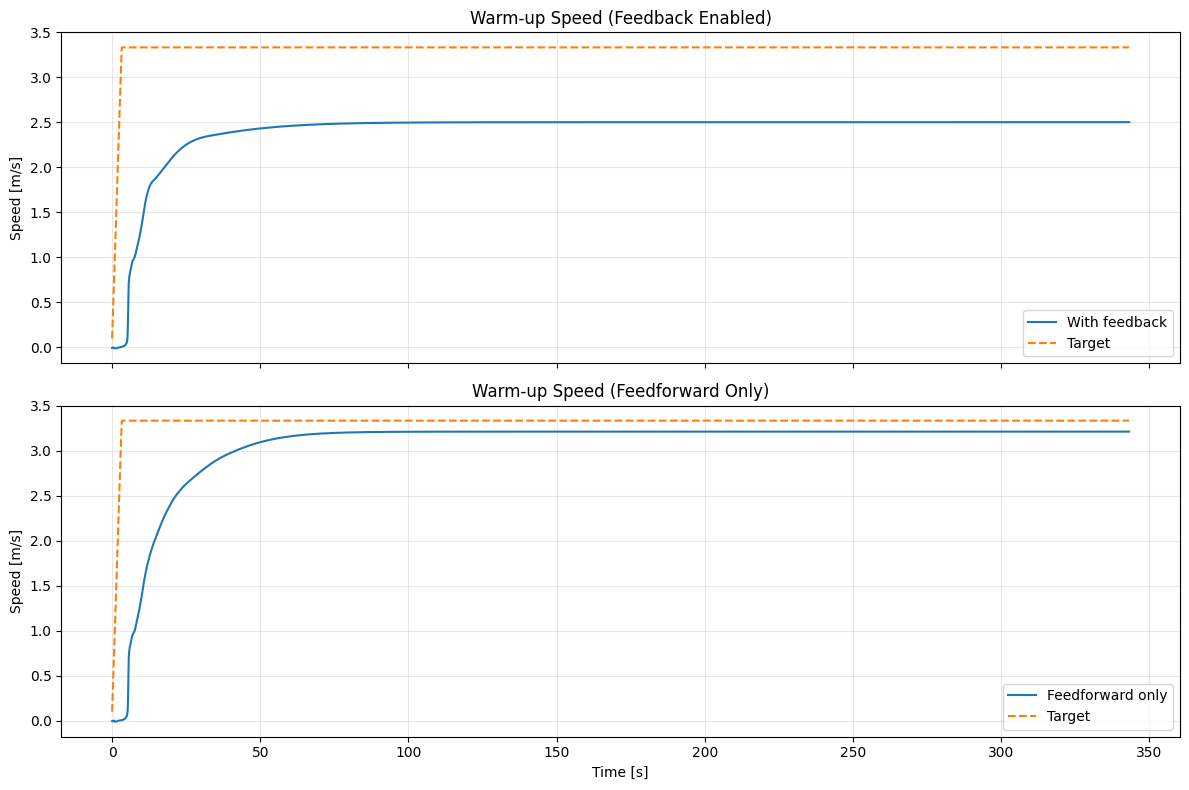

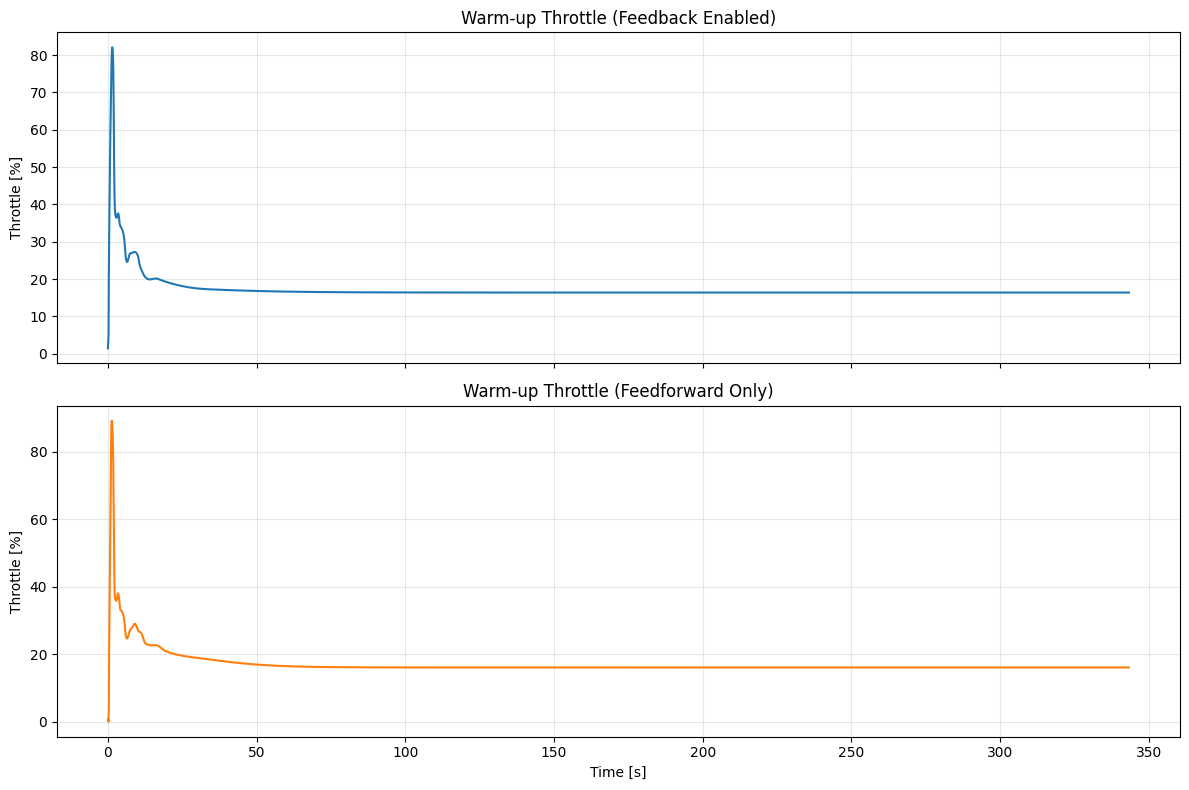

In [11]:
warmup_ff = results_clean_ff.get("warmup", {})
warmup_fb = results_clean_fb.get("warmup", {})

if warmup_ff and warmup_fb:
    t_ff = np.arange(warmup_ff["speed"].size) * SAMPLE_TIME
    t_fb = np.arange(warmup_fb["speed"].size) * SAMPLE_TIME

    fig_speed, axes_speed = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axes_speed[0].plot(t_fb, warmup_fb["speed"], label="With feedback")
    axes_speed[0].plot(t_fb, warmup_fb["target_speed"], linestyle="--", label="Target")
    axes_speed[0].set_title("Warm-up Speed (Feedback Enabled)")
    axes_speed[0].set_ylabel("Speed [m/s]")
    axes_speed[0].grid(True, alpha=0.3)
    axes_speed[0].legend(loc="lower right")

    axes_speed[1].plot(t_ff, warmup_ff["speed"], label="Feedforward only")
    axes_speed[1].plot(t_ff, warmup_ff["target_speed"], linestyle="--", label="Target")
    axes_speed[1].set_title("Warm-up Speed (Feedforward Only)")
    axes_speed[1].set_xlabel("Time [s]")
    axes_speed[1].set_ylabel("Speed [m/s]")
    axes_speed[1].grid(True, alpha=0.3)
    axes_speed[1].legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    fig_act, axes_act = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axes_act[0].plot(t_fb, warmup_fb["actions"][:, 0], label="Throttle")
    axes_act[0].set_title("Warm-up Throttle (Feedback Enabled)")
    axes_act[0].set_ylabel("Throttle [%]")
    axes_act[0].grid(True, alpha=0.3)

    axes_act[1].plot(t_ff, warmup_ff["actions"][:, 0], label="Throttle", color="tab:orange")
    axes_act[1].set_title("Warm-up Throttle (Feedforward Only)")
    axes_act[1].set_xlabel("Time [s]")
    axes_act[1].set_ylabel("Throttle [%]")
    axes_act[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Warm-up data unavailable.")


In [12]:
warmup_clean = results_clean_fb.get("warmup", {})
warmup_speed = warmup_clean.get("speed", np.array([]))
warmup_target_speed = warmup_clean.get("target_speed", np.array([]))
warmup_grade = warmup_clean.get("grade", np.array([]))
warmup_actions = warmup_clean.get("actions", np.zeros((0, 2), dtype=np.float32))
final_history_speed = results_clean_fb.get("final_history_speed", initial_speed)
final_history_actions = results_clean_fb.get("final_history_actions", initial_actions)
final_history_grade = results_clean_fb.get("final_history_grade", np.zeros_like(initial_speed))



In [13]:
# Replace the placeholder history with the post-warmup history for downstream cells
if final_history_speed.size:
    initial_speed = final_history_speed.astype(np.float32)
if final_history_actions.size:
    initial_actions = final_history_actions.astype(np.float32)
if final_history_grade.size:
    initial_grade_profile = final_history_grade.astype(np.float32)



### Warm-up Ramp Diagnostics



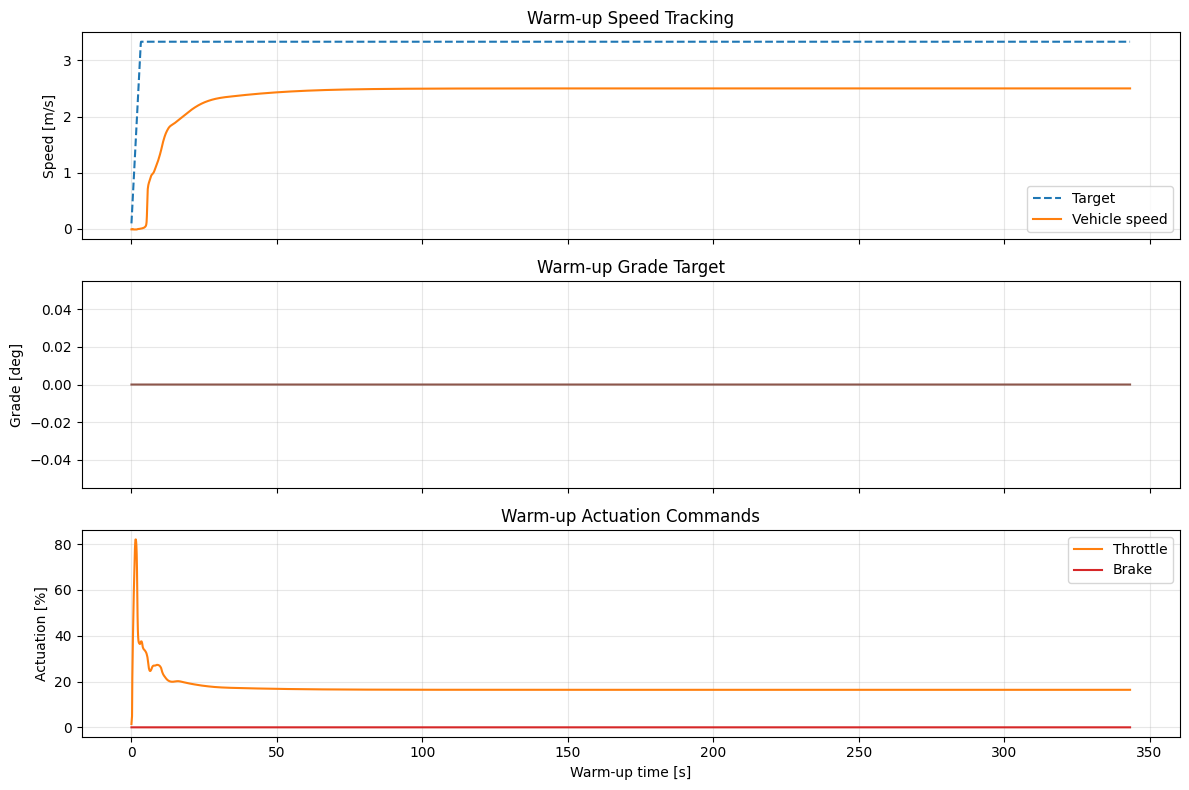

In [14]:
if warmup_speed.size:
    fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    t_warmup = np.arange(warmup_speed.size) * SAMPLE_TIME

    ax[0].plot(t_warmup, warmup_target_speed, label="Target", linestyle="--")
    ax[0].plot(t_warmup, warmup_speed, label="Vehicle speed")
    ax[0].set_ylabel("Speed [m/s]")
    ax[0].set_title("Warm-up Speed Tracking")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(t_warmup, np.degrees(warmup_grade), label="Grade (target)", color="tab:brown")
    ax[1].set_ylabel("Grade [deg]")
    ax[1].set_title("Warm-up Grade Target")
    ax[1].grid(True, alpha=0.3)

    ax[2].plot(t_warmup, warmup_actions[:, 0], label="Throttle", color="tab:orange")
    ax[2].plot(t_warmup, warmup_actions[:, 1], label="Brake", color="tab:red")
    ax[2].set_ylabel("Actuation [%]")
    ax[2].set_xlabel("Warm-up time [s]")
    ax[2].set_title("Warm-up Actuation Commands")
    ax[2].grid(True, alpha=0.3)
    ax[2].legend()

    plt.tight_layout()
    plt.show()
else:
    print("Warm-up trace unavailable (no ramp executed).")



### Plot Closed-loop Results (Clean)



### Warm-up Configuration



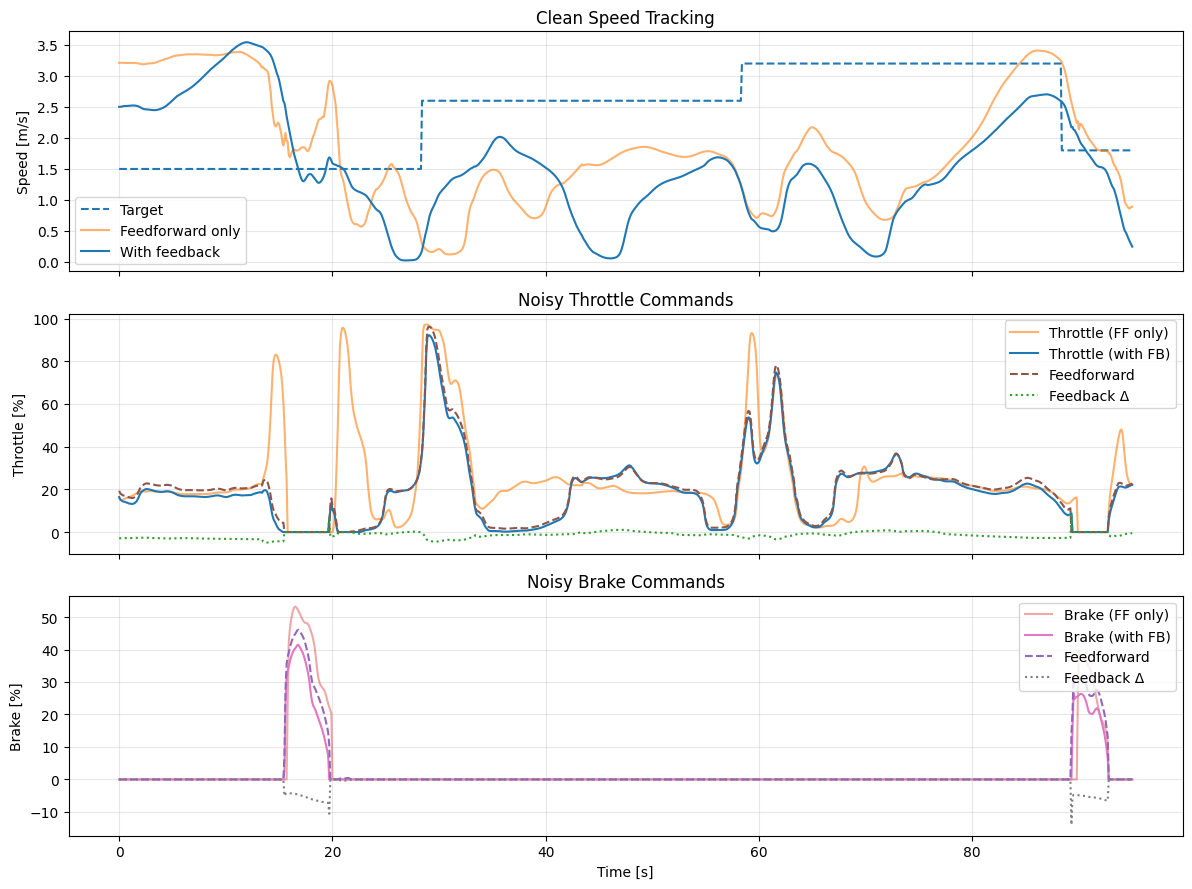

In [15]:
sim_speed_ff = results_clean_ff["simulated_speed"]
sim_speed_fb = results_clean_fb["simulated_speed"]
actuations_ff = results_clean_ff["applied_actions"]
actuations_fb = results_clean_fb["applied_actions"]
feedforward_ff = results_clean_ff.get("feedforward_actions")
feedforward_fb = results_clean_fb.get("feedforward_actions")
feedback_fb = results_clean_fb.get("feedback_actions")
time_closed = np.arange(sim_speed_fb.shape[0]) * SAMPLE_TIME

fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
ax[0].plot(time_closed, TARGET_SPEED[HISTORY:HISTORY + sim_speed_fb.shape[0]], label="Target", linestyle="--")
ax[0].plot(time_closed, sim_speed_ff, label="Feedforward only", color="tab:orange", alpha=0.6)
ax[0].plot(time_closed, sim_speed_fb, label="With feedback", color="tab:blue")
ax[0].set_ylabel("Speed [m/s]")
ax[0].set_title("Clean Speed Tracking")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(time_closed, actuations_ff[:, 0], label="Throttle (FF only)", color="tab:orange", alpha=0.6)
ax[1].plot(time_closed, actuations_fb[:, 0], label="Throttle (with FB)", color="tab:blue")
if feedforward_fb is not None:
    ax[1].plot(time_closed, feedforward_fb[:, 0], label="Feedforward", linestyle="--", color="tab:brown")
if feedback_fb is not None:
    ax[1].plot(time_closed, feedback_fb[:, 0], label="Feedback Δ", linestyle=":", color="tab:green")
ax[1].set_ylabel("Throttle [%]")
ax[1].set_title("Noisy Throttle Commands")
ax[1].grid(True, alpha=0.3)
ax[1].legend(loc="upper right")

ax[2].plot(time_closed, actuations_ff[:, 1], label="Brake (FF only)", color="tab:red", alpha=0.4)
ax[2].plot(time_closed, actuations_fb[:, 1], label="Brake (with FB)", color="tab:pink")
if feedforward_fb is not None:
    ax[2].plot(time_closed, feedforward_fb[:, 1], label="Feedforward", linestyle="--", color="tab:purple")
if feedback_fb is not None:
    ax[2].plot(time_closed, feedback_fb[:, 1], label="Feedback Δ", linestyle=":", color="tab:gray")
ax[2].set_ylabel("Brake [%]")
ax[2].set_xlabel("Time [s]")
ax[2].set_title("Noisy Brake Commands")
ax[2].grid(True, alpha=0.3)
ax[2].legend(loc="upper right")

plt.tight_layout()
plt.show()



### Closed-loop Simulation with Measurement/Actuation Noise



In [16]:
perturb_cfg = PerturbationConfig(
    speed_noise_std=0.2,   # m/s measurement noise
    speed_delay=1,         # 1-step delay in speed measurement
    grade_noise_std=0.002, # radians
    actuation_noise_std=0.05,
)

results_noisy_ff = run_closed_loop_case(None, perturb_cfg, warmup_schedule=DEFAULT_WARMUP_SCHEDULE)
results_noisy_fb = run_closed_loop_case(feedback_model, perturb_cfg, warmup_schedule=DEFAULT_WARMUP_SCHEDULE)

print(
    "Feedforward-only speed (first 10, noisy):",
    results_noisy_ff["simulated_speed"][:10],
)
print(
    "With feedback speed (first 10, noisy):",
    results_noisy_fb["simulated_speed"][:10],
)



Feedforward-only speed (first 10, noisy): [3.2087078 3.2051895 3.2080894 3.2104034 3.214565  3.2148504 3.208293
 3.2104278 3.2058115 3.2096443]
With feedback speed (first 10, noisy): [2.506263  2.4984646 2.5040722 2.5161626 2.5065396 2.5141268 2.5177562
 2.5048988 2.510091  2.509937 ]


### Plot Closed-loop Results (Noisy)



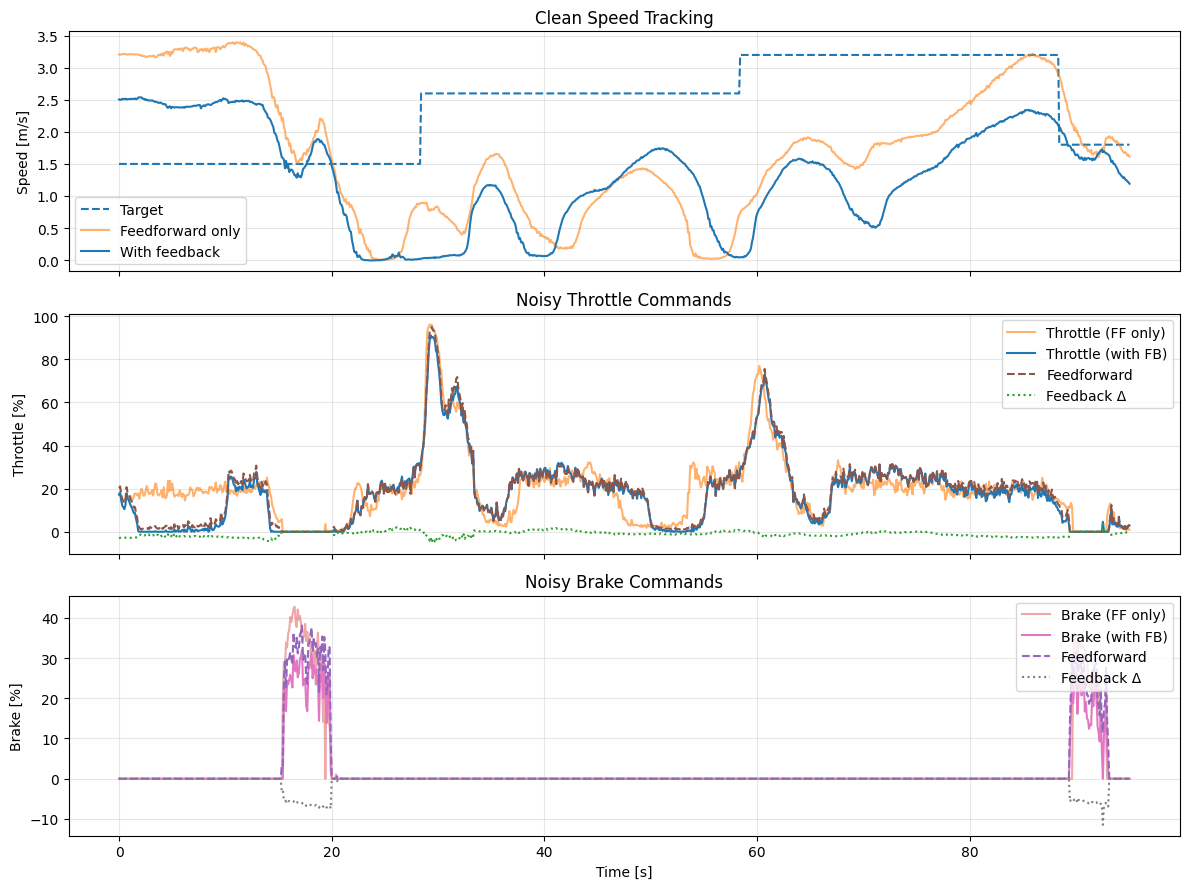

In [17]:
sim_speed_noisy_ff = results_noisy_ff["simulated_speed"]
sim_speed_noisy_fb = results_noisy_fb["simulated_speed"]
actuations_noisy_ff = results_noisy_ff["applied_actions"]
actuations_noisy_fb = results_noisy_fb["applied_actions"]
feedforward_noisy_fb = results_noisy_fb.get("feedforward_actions")
feedback_noisy_fb = results_noisy_fb.get("feedback_actions")
time_noisy = np.arange(sim_speed_noisy_fb.shape[0]) * SAMPLE_TIME

fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
ax[0].plot(time_noisy, TARGET_SPEED[HISTORY:HISTORY + sim_speed_noisy_fb.shape[0]], label="Target", linestyle="--")
ax[0].plot(time_noisy, sim_speed_noisy_ff, label="Feedforward only", color="tab:orange", alpha=0.6)
ax[0].plot(time_noisy, sim_speed_noisy_fb, label="With feedback", color="tab:blue")
ax[0].set_ylabel("Speed [m/s]")
ax[0].set_title("Clean Speed Tracking")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(time_noisy, actuations_noisy_ff[:, 0], label="Throttle (FF only)", color="tab:orange", alpha=0.6)
ax[1].plot(time_noisy, actuations_noisy_fb[:, 0], label="Throttle (with FB)", color="tab:blue")
if feedforward_noisy_fb is not None:
    ax[1].plot(time_noisy, feedforward_noisy_fb[:, 0], label="Feedforward", linestyle="--", color="tab:brown")
if feedback_noisy_fb is not None:
    ax[1].plot(time_noisy, feedback_noisy_fb[:, 0], label="Feedback Δ", linestyle=":", color="tab:green")
ax[1].set_ylabel("Throttle [%]")
ax[1].set_title("Noisy Throttle Commands")
ax[1].grid(True, alpha=0.3)
ax[1].legend(loc="upper right")

ax[2].plot(time_noisy, actuations_noisy_ff[:, 1], label="Brake (FF only)", color="tab:red", alpha=0.4)
ax[2].plot(time_noisy, actuations_noisy_fb[:, 1], label="Brake (with FB)", color="tab:pink")
if feedforward_noisy_fb is not None:
    ax[2].plot(time_noisy, feedforward_noisy_fb[:, 1], label="Feedforward", linestyle="--", color="tab:purple")
if feedback_noisy_fb is not None:
    ax[2].plot(time_noisy, feedback_noisy_fb[:, 1], label="Feedback Δ", linestyle=":", color="tab:gray")
ax[2].set_ylabel("Brake [%]")
ax[2].set_xlabel("Time [s]")
ax[2].set_title("Noisy Brake Commands")
ax[2].grid(True, alpha=0.3)
ax[2].legend(loc="upper right")

plt.tight_layout()
plt.show()



## 7. Compare Noise-Free vs Perturbed Controllers
Run the closed-loop simulation twice to quantify the effect of measurement noise.



In [18]:
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def compute_rmse(results):
    target = TARGET_SPEED[HISTORY:HISTORY + results["simulated_speed"].shape[0]]
    return rmse(target, results["simulated_speed"])

print(f"Clean RMSE (FF only): {compute_rmse(results_clean_ff):.3f} m/s")
print(f"Clean RMSE (with FB): {compute_rmse(results_clean_fb):.3f} m/s")
print(f"Noisy RMSE (FF only): {compute_rmse(results_noisy_ff):.3f} m/s")
print(f"Noisy RMSE (with FB): {compute_rmse(results_noisy_fb):.3f} m/s")



Clean RMSE (FF only): 1.433 m/s
Clean RMSE (with FB): 1.570 m/s
Noisy RMSE (FF only): 1.493 m/s
Noisy RMSE (with FB): 1.587 m/s


### Feedforward vs Feedback (Clean Simulation)



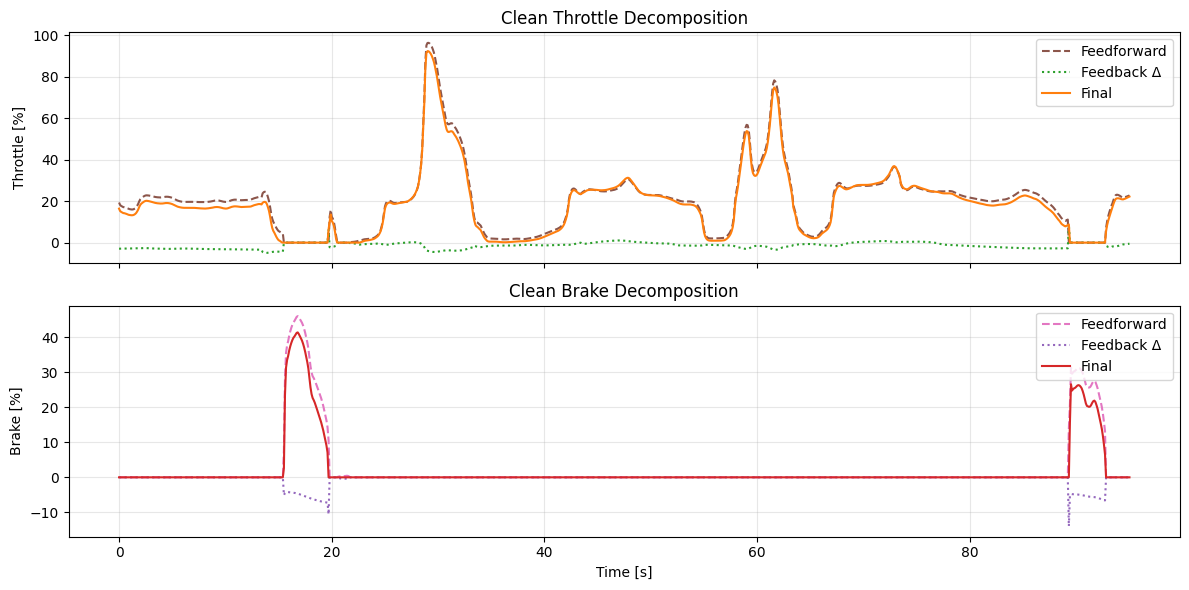

In [19]:
clean_feedforward_fb = results_clean_fb.get("feedforward_actions")
clean_feedback_fb = results_clean_fb.get("feedback_actions")
if clean_feedforward_fb is not None and clean_feedback_fb is not None:
    time_clean = np.arange(clean_feedforward_fb.shape[0]) * SAMPLE_TIME

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(time_clean, clean_feedforward_fb[:, 0], label="Feedforward", color="tab:brown", linestyle="--")
    ax[0].plot(time_clean, clean_feedback_fb[:, 0], label="Feedback Δ", color="tab:green", linestyle=":")
    ax[0].plot(time_clean, clean_feedforward_fb[:, 0] + clean_feedback_fb[:, 0], label="Final", color="tab:orange")
    ax[0].set_ylabel("Throttle [%]")
    ax[0].set_title("Clean Throttle Decomposition")
    ax[0].grid(True, alpha=0.3)
    ax[0].legend(loc="upper right")

    ax[1].plot(time_clean, clean_feedforward_fb[:, 1], label="Feedforward", color="tab:pink", linestyle="--")
    ax[1].plot(time_clean, clean_feedback_fb[:, 1], label="Feedback Δ", color="tab:purple", linestyle=":")
    ax[1].plot(time_clean, clean_feedforward_fb[:, 1] + clean_feedback_fb[:, 1], label="Final", color="tab:red")
    ax[1].set_ylabel("Brake [%]")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_title("Clean Brake Decomposition")
    ax[1].grid(True, alpha=0.3)
    ax[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()
else:
    print("Feedforward/feedback signals not available in clean results.")



### Plot Comparison



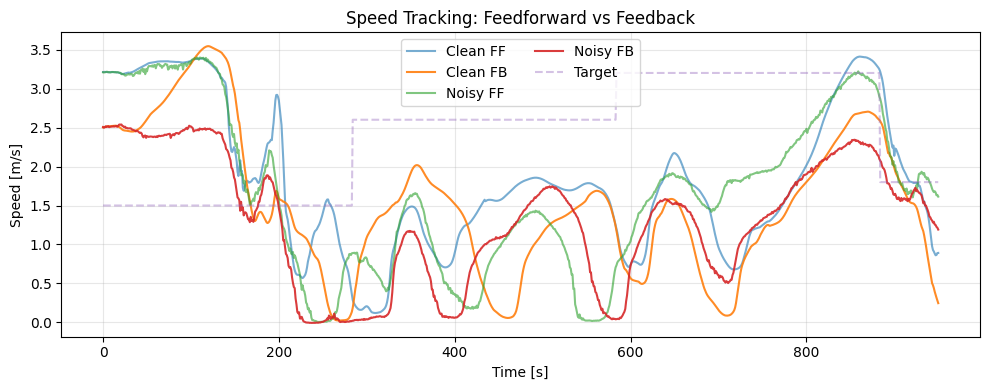

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(results_clean_ff["simulated_speed"], label="Clean FF", alpha=0.6)
ax.plot(results_clean_fb["simulated_speed"], label="Clean FB", alpha=0.9)
ax.plot(results_noisy_ff["simulated_speed"], label="Noisy FF", alpha=0.6)
ax.plot(results_noisy_fb["simulated_speed"], label="Noisy FB", alpha=0.9)
ax.plot(
    TARGET_SPEED[HISTORY:HISTORY + len(results_clean_fb["simulated_speed"])],
    label="Target",
    linestyle="--",
    alpha=0.4,
)
ax.set_title("Speed Tracking: Feedforward vs Feedback")
ax.set_ylabel("Speed [m/s]")
ax.set_xlabel("Time [s]")
ax.legend(ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



### Inference Performance
We benchmark single forward passes for the trained models to understand realtime feasibility.



In [21]:
from src.data.datasets import EVSequenceDataset, SequenceWindowConfig as DSWindowConfig

timing_dataset = EVSequenceDataset(
    DATASET_PATH,
    window=DSWindowConfig(history=HISTORY, horizon=HORIZON),
)
sample = timing_dataset[0]

history_states_t = sample["history_states"].unsqueeze(0).to(device)
history_actions_t = sample["history_actions"].unsqueeze(0).to(device)
future_states_t = sample["future_states"].unsqueeze(0).to(device)
future_actions_t = sample["future_actions"].unsqueeze(0).to(device)
history_residual_t = torch.zeros_like(history_actions_t)

forward_model.eval()
inverse_model.eval()
feedback_model.eval()

if device.type == "cuda":
    torch.cuda.synchronize()


def measure_latency(fn, warmup: int = 10, iters: int = 100) -> float:
    if device.type == "cuda":
        torch.cuda.synchronize()
    for _ in range(warmup):
        fn()
    if device.type == "cuda":
        torch.cuda.synchronize()
    start = pytime.perf_counter()
    for _ in range(iters):
        fn()
    if device.type == "cuda":
        torch.cuda.synchronize()
    end = pytime.perf_counter()
    return (end - start) / iters


@torch.no_grad()
def run_inverse():
    return inverse_model(history_states_t, history_actions_t, future_states_t)


def run_forward(actions: torch.Tensor):
    with torch.no_grad():
        return forward_model(history_states_t, history_actions_t, actions)


feedforward_baseline = run_inverse()

@torch.no_grad()
def run_feedback():
    return feedback_model(
        history_states_t,
        history_actions_t,
        future_states_t,
        feedforward_baseline,
        history_residual_actions=history_residual_t,
    )

lat_inverse = measure_latency(run_inverse)
lat_feedback = measure_latency(run_feedback)
lat_forward_gt = measure_latency(lambda: run_forward(future_actions_t))
lat_forward_ff = measure_latency(lambda: run_forward(feedforward_baseline))

print(
    f"Inverse model latency: {lat_inverse * 1e3:.3f} ms",
    f"Feedback model latency: {lat_feedback * 1e3:.3f} ms",
    f"Forward model latency (GT actuations): {lat_forward_gt * 1e3:.3f} ms",
    f"Forward model latency (FF actuations): {lat_forward_ff * 1e3:.3f} ms",
    sep="\n",
)



/opt/imagry/DynamicsNet/src/data/datasets.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(data_path)


Inverse model latency: 0.615 ms
Feedback model latency: 0.636 ms
Forward model latency (GT actuations): 0.605 ms
Forward model latency (FF actuations): 0.604 ms


## 8. Next Steps
- Swap the synthetic profiles with recorded data (`np.load`).
- Tune `PerturbationConfig` to emulate additional disturbances (e.g., wheel slip).
- Integrate the loop into larger planning stacks for MPC benchmarking.

